In [4]:
import os
import yaml
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import jensenshannon
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
from func import *
from helpers import *
from xgboost import XGBClassifier
from sklearn. metrics import accuracy_score
from scipy.spatial.distance import jensenshannon
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [70]:
CONFIG_PATH = Path("/mnt/c/Users/nahomw/Desktop/from_mac/nahomworku/Desktop/uthealth/gra_project/synthetic-population/config/params.yaml")
with open(CONFIG_PATH) as file:
    params_ = yaml.safe_load(file)
input_files = params_['evaluate']['input']
output_path = Path(params_['evaluate']['output'][0])
output_path.mkdir(parents=True, exist_ok=True)
df_train = pd.read_csv(input_files[0], low_memory=False)
df_test = pd.read_csv(input_files[1], low_memory=False)
df_train2 = pd.read_csv(input_files[2], low_memory=False)


In [71]:
df_test.shape, int(df_train2.shape[0]) + int(df_test.shape[0])

((88689, 16), 443443)

In [72]:
df = pd.concat([df_train2,df_test],axis = 0)
df.shape, df_train.shape

((443443, 16), (100000, 16))

### METHOD 1: CHECK DISTRIBUTION

In [73]:
df.head()

,RECORD_ID,DISCHARGE,TYPE_OF_ADMISSION,SOURCE_OF_ADMISSION,PAT_ZIP,PAT_COUNTY,PUBLIC_HEALTH_REGION,PAT_STATUS,SEX_CODE,RACE,ETHNICITY,ADMIT_WEEKDAY,LENGTH_OF_STAY,PAT_AGE,FIRST_PAYMENT_SRC,APR_MDC
0,120236388234,2023Q1,1,1,77708.0,245.0,5.0,7,M,4,2.0,6,4,09,ZZ,1
1,120232244836,2023Q1,1,4,NaN,85.0,3.0,1,NaN,4,2.0,1,7,25,OF,6
2,120233171564,2023Q1,1,1,NaN,439.0,3.0,1,NaN,4,1.0,3,5,25,16,7
3,120231704794,2023Q1,1,1,76543.0,27.0,7.0,1,M,4,2.0,4,3,17,MA,5
4,120233277300,2023Q1,1,1,79764,135.0,9.0,1,F,4,1.0,6,21,09,CI,18


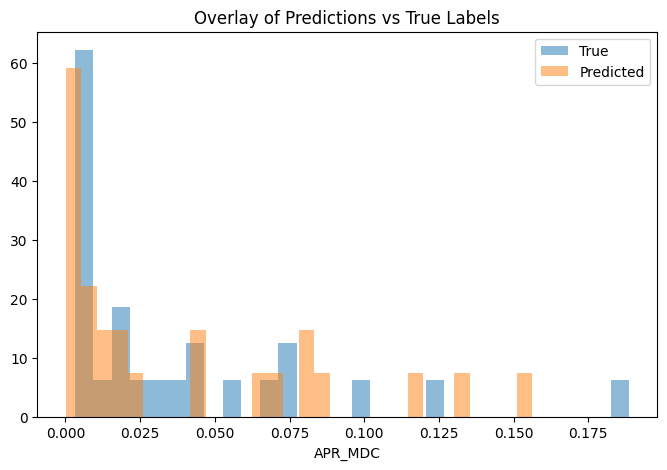

Similarity from Jenson Shannon :  90.0414526774508 %


In [74]:
dist_match(df_train['APR_MDC'].value_counts(normalize=True),df['APR_MDC'].value_counts(normalize=True), class_ = 'APR_MDC')
# 1 - jensenshannon(df_train['APR_MDC'].value_counts(normalize=True),df['APR_MDC'].value_counts(normalize=True))

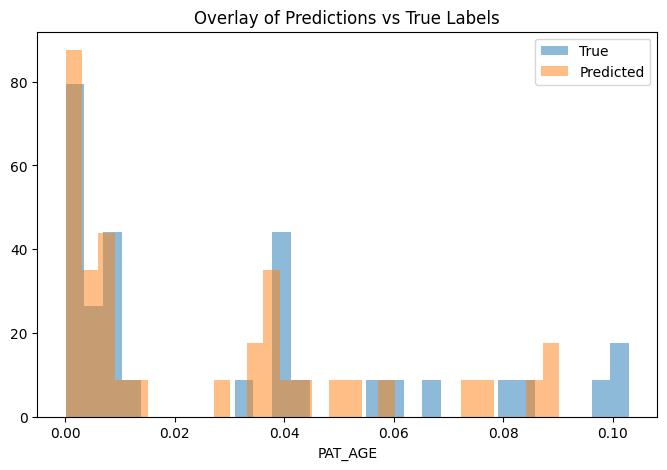

ValueError: operands could not be broadcast together with shapes (33,) (38,) 

In [75]:
dist_match(df_train['PAT_AGE'].value_counts(normalize=True),df['PAT_AGE'].value_counts(normalize=True), class_ = 'PAT_AGE')


### VALIDATE MODEL 1

In [ ]:
def preprocess(df):

    df_ = df.copy()
    cat_cols = ['DISCHARGE','TYPE_OF_ADMISSION', 'SOURCE_OF_ADMISSION',
                'PUBLIC_HEALTH_REGION', 'PAT_STATUS', 'SEX_CODE', 'RACE', 'ETHNICITY', 'ADMIT_WEEKDAY','PAT_AGE']
    for col in cat_cols:
        df_[col] = df_[col].astype(str)
        le = LabelEncoder()
        df_[col] = le.fit_transform(df_[col])
    num_cols = ['LENGTH_OF_STAY']
    X = df_[cat_cols + num_cols]
    y = df_['APR_MDC']
    return X, y
X_train, y_train = preprocess(df_train)
X_test, y_test = preprocess(df_test)
y_train.head()


0    19
1     6
2     5
3     4
4    10
Name: APR_MDC, dtype: int64

In [ ]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

# --- Define model ---
model = XGBClassifier(
    objective='multi:softprob',
    n_estimators=200,
    learning_rate=0.01,
    max_depth=12,
    random_state=42,
    enable_categorical=True,
    eval_metric='mlogloss'
)

def train_model(model, X_train, y_train, X_test, y_test):
    # ✅ Encode target variable
    le_y = LabelEncoder()
    y_train_enc = le_y.fit_transform(y_train)

    # Handle unseen classes in test set
    unseen = set(y_test.unique()) - set(le_y.classes_)
    if unseen:
        print(f"⚠️ Warning: unseen classes in test set: {unseen}")
        # Map unseen classes to a known label (e.g., first class)
        y_test = y_test.apply(lambda x: x if x in le_y.classes_ else le_y.classes_[0])

    y_test_enc = le_y.transform(y_test)

    # ✅ Encode categorical features
    X_train = X_train.copy()
    X_test = X_test.copy()
    encoders = {}
    for col in X_train.columns:
        if X_train[col].dtype == 'object' or X_train[col].dtype.name == 'category':
            le = LabelEncoder()
            X_train[col] = le.fit_transform(X_train[col].astype(str))
            # unseen categories in test handled safely
            X_test[col] = X_test[col].apply(lambda x: x if x in le.classes_ else le.classes_[0])
            X_test[col] = le.transform(X_test[col].astype(str))
            encoders[col] = le

    # ✅ Fit model
    model.fit(X_train, y_train_enc)

    # ✅ Predict
    pred_enc = model.predict(X_test)
    pred = le_y.inverse_transform(pred_enc)

    # ✅ Combine results
    df_pred = X_test.copy()
    df_pred['y_true'] = y_test.values
    df_pred['y_pred'] = pred

    # ✅ Accuracy
    acc = accuracy_score(y_test, pred)
    print(f"✅ Model Accuracy: {acc:.4f}")

    return df_pred, model, encoders, le_y


# --- Example usage ---
df_pred, trained_model, feature_encoders, target_encoder = train_model(
    model, X_train, y_train, X_test, y_test
)

print(df_pred.head())


NameError: name 'X_train' is not defined

In [ ]:
# dist_match(df_pred['y_pred'],df_pred['y_true'])

### EVALUATING ON OVERALL REAL DATASETS

In [76]:
df_test.shape, df_train2.shape
df_test_ = pd.concat([df_train2,df_test])
df_test_.shape

(443443, 16)

In [77]:
def preprocess(df):

    df_ = df.copy()
    cat_cols = ['DISCHARGE','TYPE_OF_ADMISSION', 'SOURCE_OF_ADMISSION',
                'PUBLIC_HEALTH_REGION', 'PAT_STATUS', 'SEX_CODE', 'RACE', 'ETHNICITY', 'ADMIT_WEEKDAY','PAT_AGE']
    for col in cat_cols:
        df_[col] = df_[col].astype(str)
        le = LabelEncoder()
        df_[col] = le.fit_transform(df_[col])
    num_cols = ['LENGTH_OF_STAY']
    X = df_[cat_cols + num_cols]
    y = df_['APR_MDC']
    return X, y
X_train, y_train = preprocess(df_train)
X_test, y_test = preprocess(df_test_)


In [78]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

# --- Define model ---
model = XGBClassifier(
    objective='multi:softprob',
    n_estimators=200,
    learning_rate=0.01,
    max_depth=12,
    random_state=42,
    enable_categorical=True,
    eval_metric='mlogloss'
)

def train_model(model, X_train, y_train, X_test, y_test):
    # ✅ Encode target variable
    le_y = LabelEncoder()
    y_train_enc = le_y.fit_transform(y_train)

    # Handle unseen classes in test set
    unseen = set(y_test.unique()) - set(le_y.classes_)
    if unseen:
        print(f"⚠️ Warning: unseen classes in test set: {unseen}")
        # Map unseen classes to a known label (e.g., first class)
        y_test = y_test.apply(lambda x: x if x in le_y.classes_ else le_y.classes_[0])

    y_test_enc = le_y.transform(y_test)

    # ✅ Encode categorical features
    X_train = X_train.copy()
    X_test = X_test.copy()
    encoders = {}
    for col in X_train.columns:
        if X_train[col].dtype == 'object' or X_train[col].dtype.name == 'category':
            le = LabelEncoder()
            X_train[col] = le.fit_transform(X_train[col].astype(str))
            # unseen categories in test handled safely
            X_test[col] = X_test[col].apply(lambda x: x if x in le.classes_ else le.classes_[0])
            X_test[col] = le.transform(X_test[col].astype(str))
            encoders[col] = le

    # ✅ Fit model
    model.fit(X_train, y_train_enc)

    # ✅ Predict
    pred_enc = model.predict(X_test)
    pred = le_y.inverse_transform(pred_enc)

    # ✅ Combine results
    df_pred = X_test.copy()
    df_pred['y_true'] = y_test.values
    df_pred['y_pred'] = pred

    # ✅ Accuracy
    acc = accuracy_score(y_test, pred)
    print(f"✅ Model Accuracy: {acc:.4f}")

    return df_pred, model, encoders, le_y


# --- Example usage ---
df_pred, trained_model, feature_encoders, target_encoder = train_model(
    model, X_train, y_train, X_test, y_test
)

print(df_pred.head())


✅ Model Accuracy: 0.1177
   DISCHARGE  TYPE_OF_ADMISSION  SOURCE_OF_ADMISSION  PUBLIC_HEALTH_REGION  \
0          1                  0                    0                     6   
1          1                  0                    2                     4   
2          1                  0                    0                     4   
3          1                  0                    0                     8   
4          1                  0                    0                    10   

   PAT_STATUS  SEX_CODE  RACE  ETHNICITY  ADMIT_WEEKDAY  PAT_AGE  \
0          20         1     3          3              5       10   
1           0         3     3          3              0       28   
2           0         3     3          1              2       28   
3           0         1     3          3              3       19   
4           0         0     3          1              5       10   

   LENGTH_OF_STAY  y_true  y_pred  
0               4       1       5  
1               7       6

In [79]:
dist_match(df_pred['y_pred'],df_pred['y_true'])

TypeError: dist_match() missing 1 required positional argument: 'class_'

In [ ]:
df_test_.shape, df_train.shape

((443443, 16), (100000, 16))

In [ ]:
dist_match(df_test_['APR_MDC'].value_counts(normalize=True), df_train['APR_MDC'].value_counts(normalize=True))

TypeError: dist_match() missing 1 required positional argument: 'class_'

In [ ]:
df_test_.shape, df_train.shape

((443443, 16), (100000, 16))

In [ ]:
df_test_['PAT_AGE'].value_counts(normalize=True), df_train['PAT_AGE'].value_counts(normalize=True)

(PAT_AGE
 17    0.090244
 18    0.087565
 16    0.086430
 15    0.076621
 19    0.073038
 14    0.059615
 20    0.053094
 13    0.050428
 24    0.044982
 23    0.039608
 12    0.039015
 21    0.037529
 09    0.037234
 10    0.036580
 08    0.035581
 11    0.035312
 07    0.028971
 25    0.013724
 02    0.011129
 06    0.007814
 01    0.007794
 03    0.007180
 04    0.006939
 05    0.006867
 26    0.004968
 9     0.004670
 8     0.004456
 7     0.003804
 00    0.002253
 2     0.001141
 6     0.001060
 22    0.000985
 5     0.000870
 4     0.000773
 3     0.000751
 1     0.000715
 0     0.000176
 `     0.000083
 Name: proportion, dtype: float64,
 PAT_AGE
 17    0.10298
 18    0.09965
 16    0.09644
 15    0.08469
 19    0.08151
 14    0.06647
 20    0.05927
 13    0.05589
 12    0.04281
 08    0.04058
 21    0.04057
 09    0.04042
 10    0.04021
 11    0.03876
 07    0.03243
 02    0.01171
 03    0.00855
 04    0.00855
 01    0.00855
 06    0.00829
 05    0.00770
 8     0.00546
 9     0.

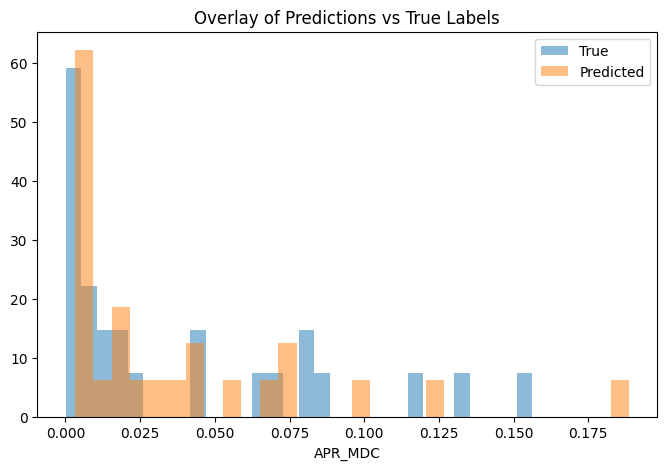

Similarity from Jenson Shannon :  90.0414526774508 %


In [ ]:
dist_match(df_test_['APR_MDC'].value_counts(normalize=True), df_train['APR_MDC'].value_counts(normalize=True), class_= 'APR_MDC')

In [ ]:
(1-0.096)*100

90.4

### VISUALIZATION MATCHING DISTRIBUTIONS

In [80]:
df.shape, df_train.shape

((443443, 16), (100000, 16))

In [28]:
df_js.loc[df["RACE" == '`']]

NameError: name 'df_js' is not defined

In [29]:
def dist_heat(df_train, df_synth, col_1, col_2):

    dist_train_1 = df_train[col_1].value_counts(normalize=True).sort_index()
    dist_train_2 = df_train[col_2].value_counts(normalize=True).sort_index()
    dist_synth_1 = df_synth[col_1].value_counts(normalize=True).sort_index()
    dist_synth_2 = df_synth[col_2].value_counts(normalize=True).sort_index()
    # Align indices
    all_indices = dist_train_1.index.union(dist_synth_1.index)
    dist_train_1 = dist_train_1.reindex(all_indices, fill_value=0)
    dist_synth_1 = dist_synth_1.reindex(all_indices, fill_value=0)
    all_indices = dist_train_2.index.union(dist_synth_2.index)
    dist_train_2 = dist_train_2.reindex(all_indices, fill_value=0)
    dist_synth_2 = dist_synth_2.reindex(all_indices, fill_value=0)
    # Compute Jensen-Shannon distance
    js_distance_1 = jensenshannon(dist_train_1, dist_synth_1)
    js_distance_2 = jensenshannon(dist_train_2, dist_synth_2)
    print(f"Jensen-Shannon distance for {col_1}: {js_distance_1:.4f}")
    print(f"Jensen-Shannon distance for {col_2}: {js_distance_2:.4f}")
    return js_distance_1, js_distance_2
    

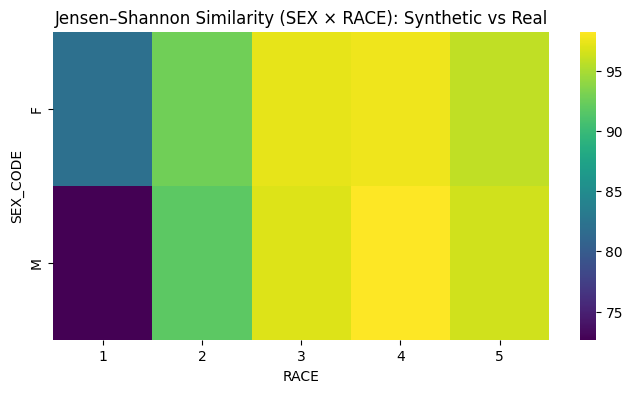

Jensen–Shannon Similarity Matrix (2×5):
RACE            1        2        3        4        5
SEX_CODE                                             
F         82.0374  92.6657  97.3057  97.5850  95.8061
M         72.6692  91.7490  96.8564  98.2287  96.4258


In [133]:
def detail_dist(df_real, df_synth, col_1, col_2) -> pd.DataFrame:

    # Step 1: PAT_AGE categories from BOTH datasets, 
    '''
    Now we used PAT_AGE instead of PAT_AGE, we can switch back if needed
    '''
    apr_list = sorted(set(df_real["PAT_AGE"].unique()) | set(df_synth["PAT_AGE"].unique()))

    records = []

    # Loop over combinations found in REAL data
    for c1 in df_real[col_1].unique():
        for c2 in df_real[col_2].unique():

            # Subgroups
            sub_real = df_real[(df_real[col_1] == c1) & (df_real[col_2] == c2)]
            sub_synth = df_synth[(df_synth[col_1] == c1) & (df_synth[col_2] == c2)]

            # Skip empty groups
            if len(sub_real) == 0 or len(sub_synth) == 0:
                continue

            # PAT_AGE distributions
            real_dist = sub_real["PAT_AGE"].value_counts(normalize=True).reindex(apr_list, fill_value=0)
            synth_dist = sub_synth["PAT_AGE"].value_counts(normalize=True).reindex(apr_list, fill_value=0)

            # JS divergence
            js = jensenshannon(real_dist, synth_dist)
            js_similarity = (1 - js) * 100

            records.append({
                col_1: c1,
                col_2: c2,
                "JS_similarity": js_similarity,
                "JS_divergence": js,
                "N_real": len(sub_real),
                "N_synth": len(sub_synth)
            })

    return pd.DataFrame(records)


def heatmap_dist(data):
    
    plt.figure(figsize=(8, 4))
    sns.heatmap(data, annot=False, cmap="viridis", fmt=".3f")
    plt.title("Jensen–Shannon Similarity (SEX × RACE): Synthetic vs Real")
    # plt.xlabel(col_1)
    # plt.ylabel(col_2)
    plt.show()

    # ✅ Print 2×5 JS matrix
    print("Jensen–Shannon Similarity Matrix (2×5):")
    print(data.round(4))

df_js = detail_dist(df_real=df_train, df_synth=df, col_1="SEX_CODE", col_2="RACE")

# Remove RACE = "`"
df_js = df_js[df_js["RACE"] != "`"]

# Pivot: Convert long-format into matrix for heatmap
pivot_js = df_js.pivot(index="SEX_CODE", columns="RACE", values="JS_similarity")

# Optional: sort RACE columns
pivot_js = pivot_js.reindex(sorted(pivot_js.columns), axis=1)

# Plot heatmap
heatmap_dist(pivot_js)
    




In [134]:
df_test['ETHNICITY'].value_counts(normalize=True)

ETHNICITY
2.0    0.600565
1.0    0.253577
2      0.098192
1      0.047655
`      0.000011
Name: proportion, dtype: float64

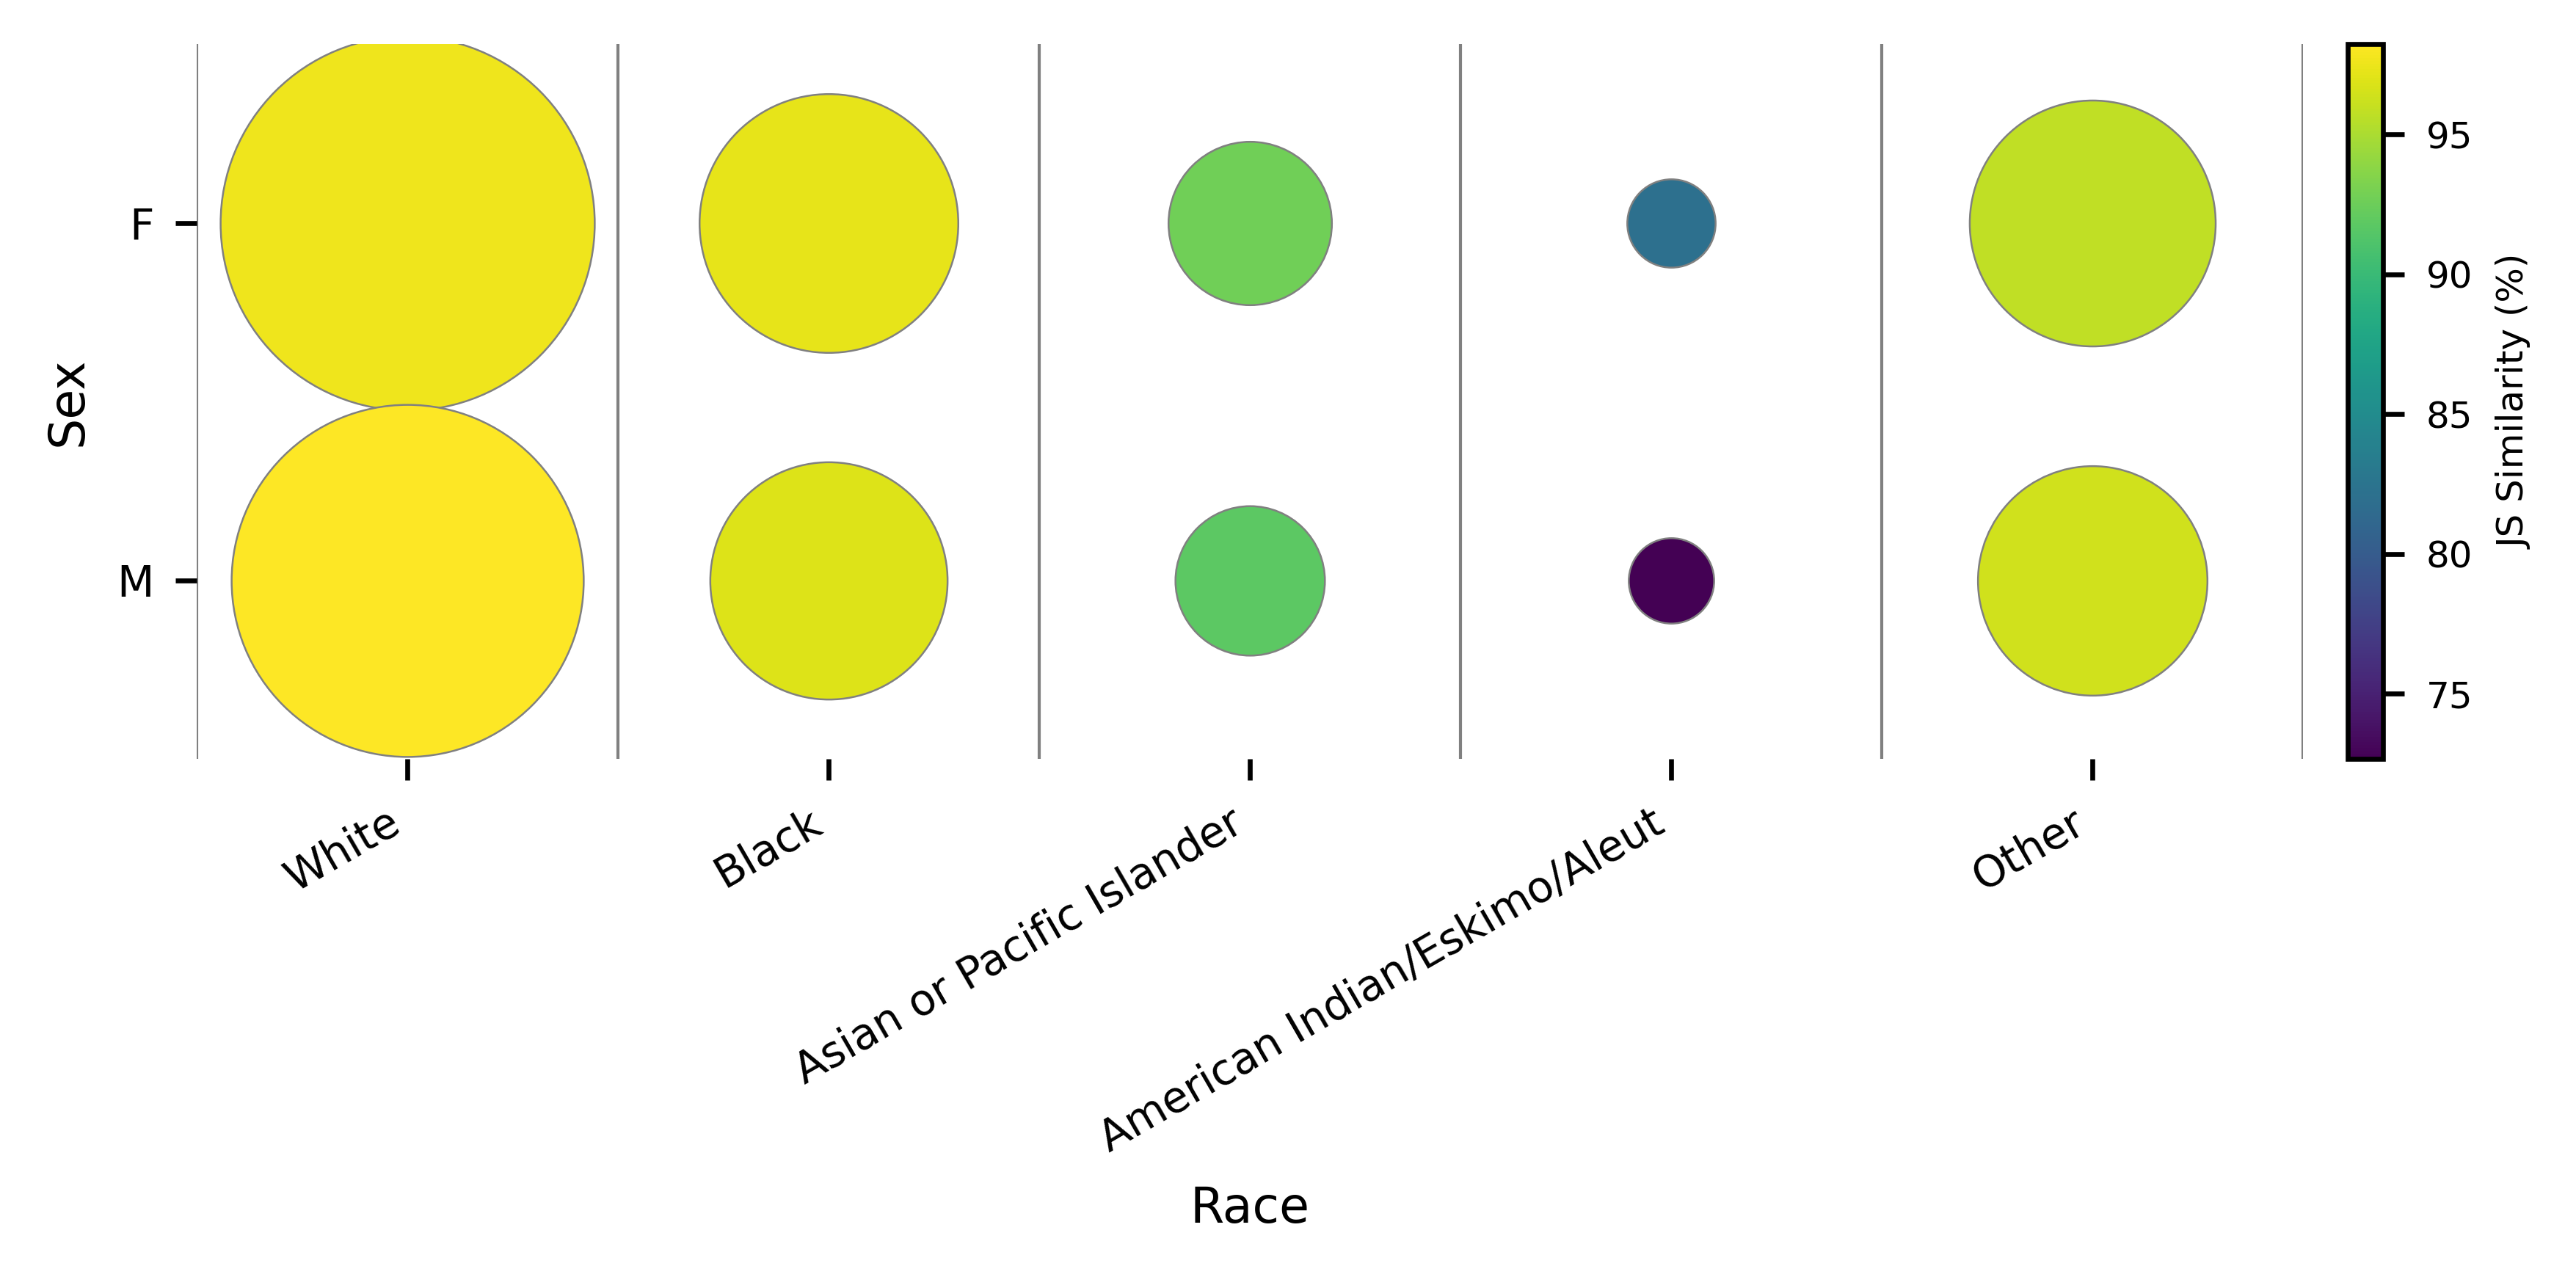

In [135]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import Normalize
# Change from APR_MDC to PAT_AGE

# -----------------------------
# Map race codes to labels
# -----------------------------
race_map = {
    "4": "White",
    "3": "Black",
    "2": "Asian or Pacific Islander",
    "1": "American Indian/Eskimo/Aleut",
    "5": "Other"
}
race_order = list(race_map.values())

# -----------------------------
# Filter valid races
# -----------------------------
df_js_plot = df_js[df_js["RACE"].isin(race_map.keys())].copy()
df_js_plot["RACE_LABEL"] = df_js_plot["RACE"].map(race_map)

# -----------------------------
# Pivot for heatmap
# -----------------------------
pivot_js = df_js_plot.pivot(
    index="SEX_CODE",
    columns="RACE_LABEL",
    values="JS_similarity"
).reindex(race_order, axis=1)

# -----------------------------
# Calculate subgroup percentages
# -----------------------------
df_js_plot["TOTAL"] = df_js_plot["N_real"] + df_js_plot["N_synth"]
total_population = df_js_plot["TOTAL"].sum()
df_js_plot["PERCENTAGE"] = df_js_plot["TOTAL"] / total_population

# -----------------------------
# Figure (publication-ready)
# -----------------------------
fig_width = 6
fig_height = 3
fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=600)

# -----------------------------
# Color map for JS similarity
# -----------------------------
cmap = plt.cm.viridis
norm = Normalize(vmin=pivot_js.min().min(), vmax=pivot_js.max().max())

# -----------------------------
# Draw circular heatmap cells (size = sample %, color = JS similarity)
# -----------------------------
circle_scale = 6000  # adjust for visibility

for i, sex in enumerate(pivot_js.index):
    for j, race in enumerate(pivot_js.columns):
        js_val = pivot_js.loc[sex, race]
        pct = df_js_plot[
            (df_js_plot["SEX_CODE"] == sex) &
            (df_js_plot["RACE_LABEL"] == race)
        ]["PERCENTAGE"].values
        if len(pct) == 0 or pd.isna(js_val):
            continue
        
        # sqrt scaling for better visibility of small percentages
        size = np.sqrt(pct[0]) * circle_scale

        ax.scatter(
            j + 0.5, i + 0.5,
            s=size,
            color=cmap(norm(js_val)),
            edgecolor="gray",
            linewidth=0.3,
            zorder=2
        )

# -----------------------------
# Vertical gray lines through cells
# -----------------------------
for j in range(len(pivot_js.columns) + 1):
    ax.axvline(j, color="gray", linewidth=0.5, zorder=1)

# -----------------------------
# Axes formatting
# -----------------------------
ax.set_xlim(0, len(pivot_js.columns))
ax.set_ylim(len(pivot_js.index), 0)

ax.set_xticks(np.arange(len(pivot_js.columns)) + 0.5)
ax.set_xticklabels(pivot_js.columns, rotation=30, ha="right", fontsize=7)

ax.set_yticks(np.arange(len(pivot_js.index)) + 0.5)
ax.set_yticklabels(pivot_js.index, fontsize=7)

ax.set_xlabel("Race", fontsize=8)
ax.set_ylabel("Sex", fontsize=8)

ax.set_facecolor("white")
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(left=True, bottom=True)

# -----------------------------
# Colorbar for JS similarity
# -----------------------------
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.035, pad=0.02)
cbar.set_label("JS Similarity (%)", fontsize=6)
cbar.ax.tick_params(labelsize=6)

# -----------------------------
# Circle size legend (top-right)
# -----------------------------
legend_sizes = [0.01, 0.03, 0.06]
legend_handles = [
    plt.scatter([], [], s=np.sqrt(p)*circle_scale, color="gray", alpha=0.7,
                edgecolor="gray", linewidth=0.3)
    for p in legend_sizes
]
legend_labels = [f"{int(p*100)}% of sample" for p in legend_sizes]

# ax.legend(
#     legend_handles,
#     legend_labels,
#     title="Subgroup size",
#     bbox_to_anchor=(1.05, 1.0),
#     loc="upper left",
#     frameon=False,
#     fontsize=6,
#     title_fontsize=6
# )

plt.tight_layout()
plt.show()


### Sex-Ethnicity

In [136]:
df_train = df_train[df_train['ETHNICITY']!= '`']
df_test_ = df_test_[df_test_['ETHNICITY']!= '`']
df_train['ETHNICITY'] = df_train['ETHNICITY'].astype(float)
df_test_['ETHNICITY'] = df_test_['ETHNICITY'].astype(float)


In [137]:
df_train["SEX_CODE"].value_counts()

SEX_CODE
F    56794
M    43205
Name: count, dtype: int64

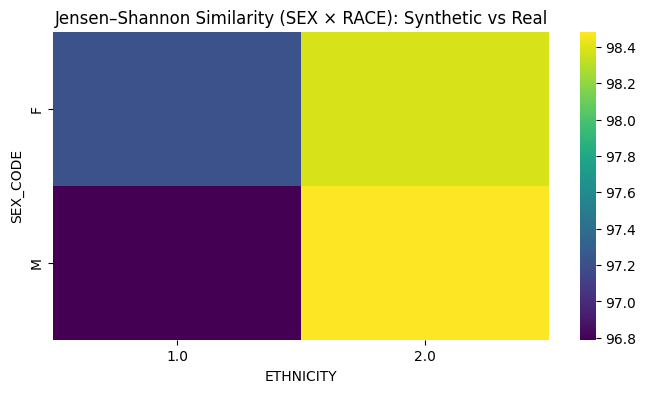

Jensen–Shannon Similarity Matrix (2×5):
ETHNICITY      1.0      2.0
SEX_CODE                   
F          97.2140  98.3837
M          96.7895  98.4837


In [138]:
df_js = detail_dist(df_real=df_train, df_synth=df_test_, col_1="SEX_CODE", col_2="ETHNICITY")

# Remove ETHNICITY = "`"
# df_js = df_js[df_js["ETHNICITY"] != "`"]

# Pivot: Convert long-format into matrix for heatmap
pivot_js = df_js.pivot(index="SEX_CODE", columns="ETHNICITY", values="JS_similarity")

# # Optional: sort ETHNICITY columns
# pivot_js = pivot_js.reindex(sorted(pivot_js.columns), axis=1)

# Plot heatmap
heatmap_dist(pivot_js)

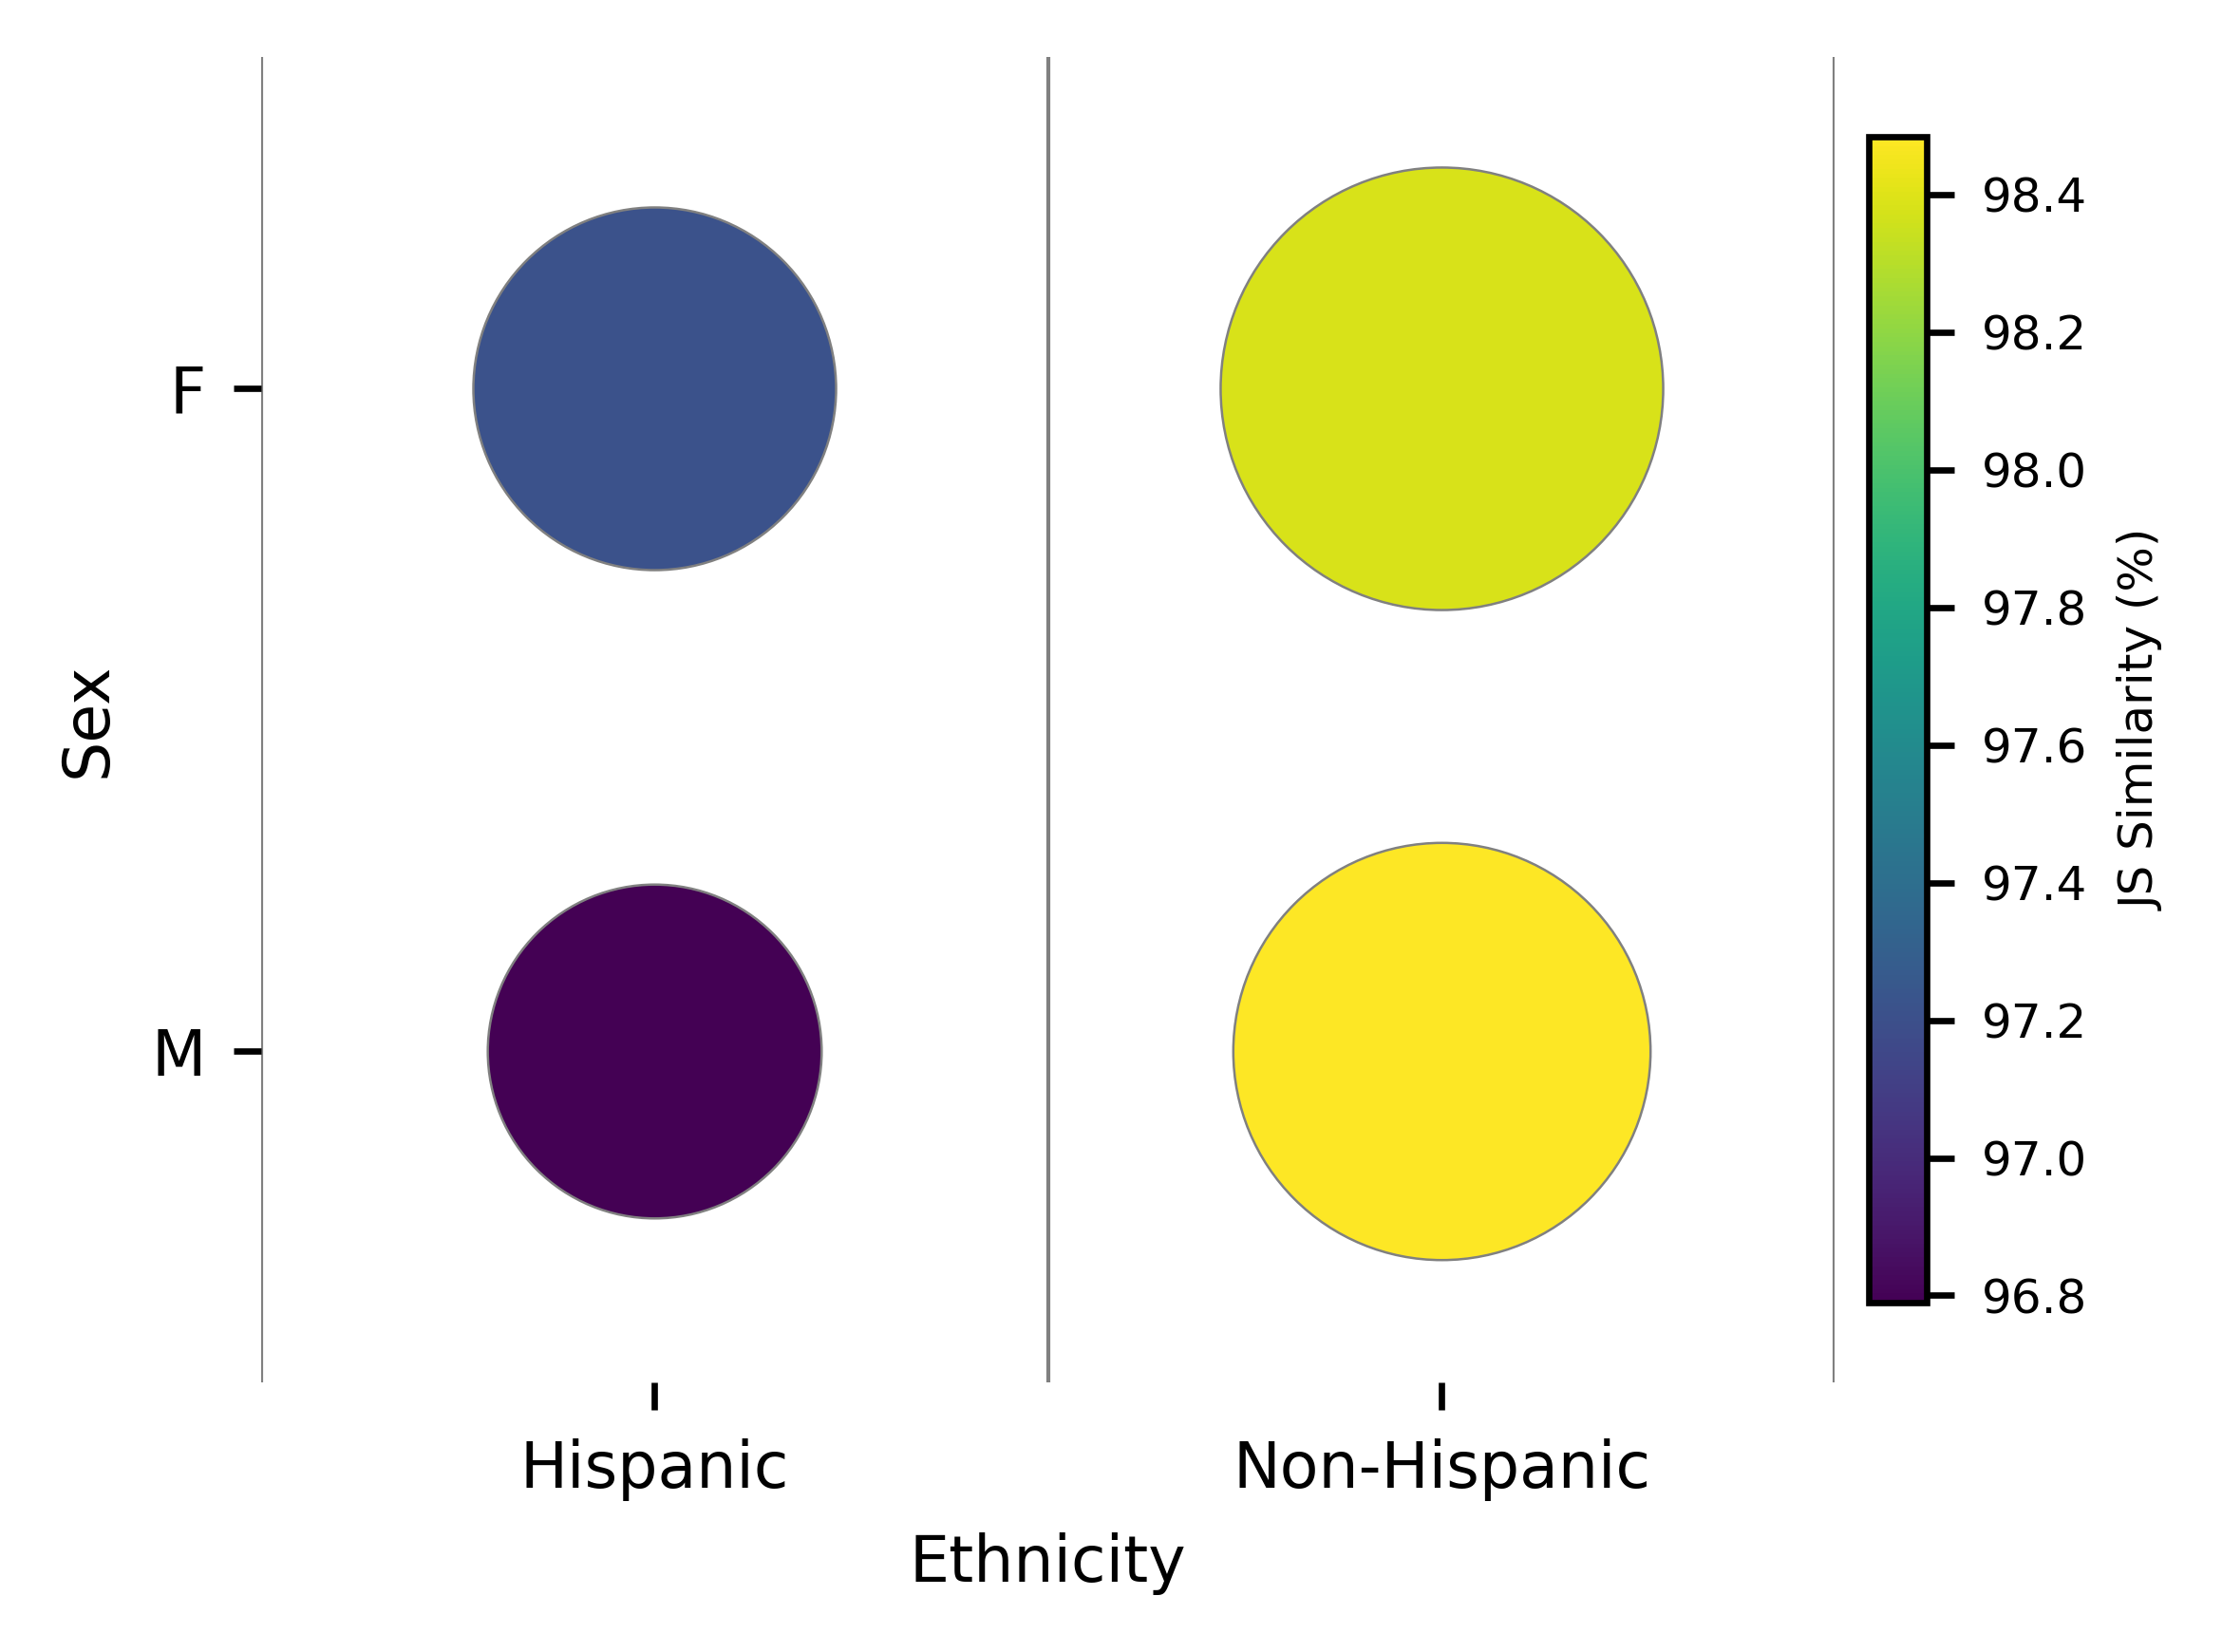

In [139]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize

# -----------------------------
# Map ethnicity codes to labels
# -----------------------------
ethnicity_map = {
    1: "Hispanic",
    2: "Non-Hispanic"
}
ethnicity_order = list(ethnicity_map.values())

# -----------------------------
# Filter valid ethnicities
# -----------------------------
df_js_plot = df_js[df_js["ETHNICITY"].isin(ethnicity_map.keys())].copy()
df_js_plot["ETHNICITY_LABEL"] = df_js_plot["ETHNICITY"].map(ethnicity_map)

# -----------------------------
# Pivot for heatmap
# -----------------------------
pivot_js = df_js_plot.pivot(
    index="SEX_CODE",
    columns="ETHNICITY_LABEL",
    values="JS_similarity"
).reindex(ethnicity_order, axis=1)

# -----------------------------
# Calculate subgroup percentages
# -----------------------------
df_js_plot["TOTAL"] = df_js_plot["N_real"] + df_js_plot["N_synth"]
total_population = df_js_plot["TOTAL"].sum()
df_js_plot["PERCENTAGE"] = df_js_plot["TOTAL"] / total_population

# -----------------------------
# Figure
# -----------------------------
fig_width = max(4, len(pivot_js.columns))
fig_height = max(3, len(pivot_js.index))
fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=600)

# -----------------------------
# Color map for JS similarity
# -----------------------------
cmap = plt.cm.viridis
norm = Normalize(vmin=pivot_js.min().min(), vmax=pivot_js.max().max())

# -----------------------------
# Draw circular heatmap cells
# -----------------------------
circle_scale = 5000  # increase to make small percentages visible

for i, sex in enumerate(pivot_js.index):
    for j, eth in enumerate(pivot_js.columns):
        js_val = pivot_js.loc[sex, eth]
        pct = df_js_plot[
            (df_js_plot["SEX_CODE"] == sex) &
            (df_js_plot["ETHNICITY_LABEL"] == eth)
        ]["PERCENTAGE"].values
        if len(pct) == 0 or np.isnan(js_val):
            continue
        
        # sqrt scaling for better visibility of small percentages
        size = np.sqrt(pct[0] + 0.001) * circle_scale

        ax.scatter(
            j + 0.5, i + 0.5,
            s=size,
            color=cmap(norm(js_val)),
            edgecolor="gray",
            linewidth=0.3,
            zorder=2
        )

# -----------------------------
# Vertical gray lines through cells
# -----------------------------
for j in range(len(pivot_js.columns) + 1):
    ax.axvline(j, color="gray", linewidth=0.5, zorder=1)

# -----------------------------
# Axes formatting
# -----------------------------
ax.set_xlim(0, len(pivot_js.columns))
ax.set_ylim(len(pivot_js.index), 0)  # invert y-axis

ax.set_xticks(np.arange(len(pivot_js.columns)) + 0.5)
ax.set_xticklabels(pivot_js.columns, rotation=0, ha="center", fontsize=8)

ax.set_yticks(np.arange(len(pivot_js.index)) + 0.5)
ax.set_yticklabels(pivot_js.index, fontsize=8)

ax.set_xlabel("Ethnicity", fontsize=8)
ax.set_ylabel("Sex", fontsize=8)

ax.set_facecolor("white")
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(left=True, bottom=True)

# -----------------------------
# Colorbar for JS similarity
# -----------------------------
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.035, pad=0.02)
cbar.set_label("JS Similarity (%)", fontsize=6)
cbar.ax.tick_params(labelsize=6)

plt.tight_layout()
plt.show()


/tmp/ipykernel_1570/546254299.py:34: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


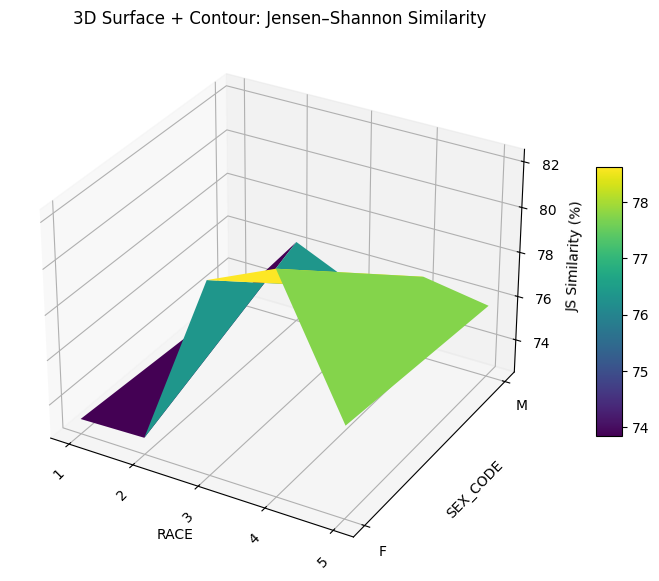

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Convert pivot table to numeric matrix
Z = pivot_js.values
x_labels = pivot_js.columns
y_labels = pivot_js.index

X, Y = np.meshgrid(np.arange(len(x_labels)), np.arange(len(y_labels)))

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')

# Surface
surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis, linewidth=0, antialiased=True)

# Contour projection
ax.contour(X, Y, Z, zdir='z', offset=0, cmap=cm.viridis)

ax.set_xticks(np.arange(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=45)
ax.set_yticks(np.arange(len(y_labels)))
ax.set_yticklabels(y_labels)

ax.set_xlabel("RACE")
ax.set_ylabel("SEX_CODE")
ax.set_zlabel("JS Similarity (%)")

fig.colorbar(surf, shrink=0.5, aspect=10)
plt.title("3D Surface + Contour: Jensen–Shannon Similarity")

plt.tight_layout()
plt.show()


In [34]:
df_train['PAT_AGE'] = pd.to_numeric(df_train['PAT_AGE'], errors='coerce')
df['PAT_AGE'] = pd.to_numeric(df['PAT_AGE'], errors='coerce')


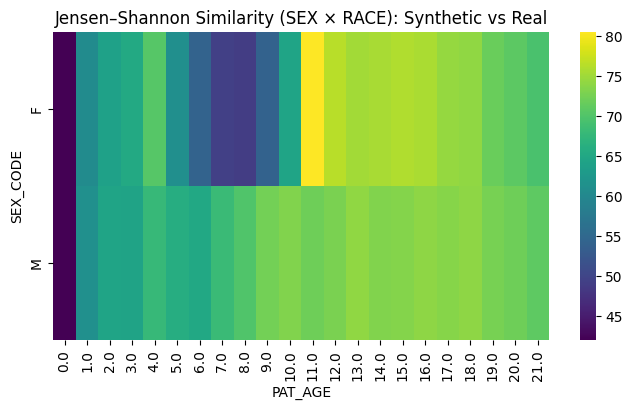

Jensen–Shannon Similarity Matrix (2×5):
PAT_AGE      0.0      1.0      2.0      3.0      4.0      5.0      6.0   \
SEX_CODE                                                                  
F         42.1090  60.4455  63.8661  65.2571  70.3298  61.1213  54.2026   
M         42.0191  61.2410  64.4561  64.3990  67.8192  66.0838  65.0940   

PAT_AGE      7.0      8.0      9.0   ...     12.0     13.0     14.0     15.0  \
SEX_CODE                             ...                                       
F         49.3450  48.8411  53.9447  ...  76.3502  75.1891  75.5709  76.0047   
M         68.0767  69.9366  72.3927  ...  72.8205  74.0947  73.2047  73.4143   

PAT_AGE      16.0     17.0     18.0     19.0     20.0     21.0  
SEX_CODE                                                        
F         75.6123  74.4332  74.1867  71.7917  70.8434  69.5236  
M         74.0375  73.5388  74.0883  72.6313  72.1131  70.9833  

[2 rows x 22 columns]


In [35]:
df_js = detail_dist(df_real=df_train, df_synth=df, col_1="PAT_AGE", col_2="SEX_CODE")
# print(df_js)
pivot_js = df_js.pivot(index="SEX_CODE", columns="PAT_AGE", values="JS_similarity")

# Optional: sort RACE columns
pivot_js = pivot_js.reindex(sorted(pivot_js.columns), axis=1)




# Plot heatmap
heatmap_dist(pivot_js)
    

In [39]:
df['PAT_AGE'].value_counts(normalize=True) * 100

PAT_AGE
17.0    9.025137
18.0    8.757211
16.0    8.643771
15.0    7.662729
19.0    7.304367
14.0    5.962030
20.0    5.309806
13.0    5.043234
24.0    4.498586
9.0     4.190742
8.0     4.004005
23.0    3.961155
12.0    3.901842
21.0    3.753219
10.0    3.658273
11.0    3.531526
7.0     3.277809
25.0    1.372557
2.0     1.227092
6.0     0.887449
1.0     0.850913
3.0     0.793178
5.0     0.773783
4.0     0.771302
26.0    0.496836
0.0     0.242893
22.0    0.098555
Name: proportion, dtype: float64

In [ ]:
with_open

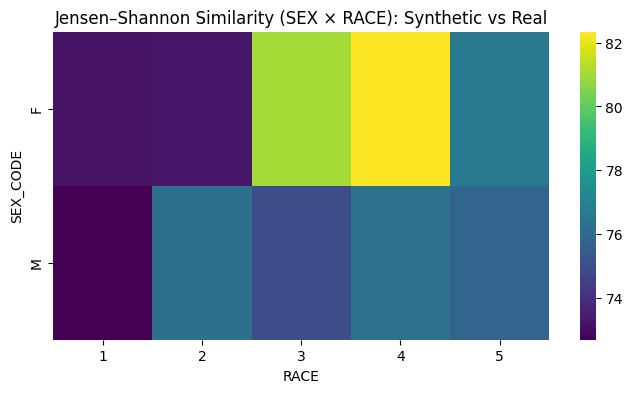

Jensen–Shannon Similarity Matrix (2×5):
RACE            1        2        3        4        5
SEX_CODE                                             
F         73.1770  73.2544  81.0362  82.3384  76.6046
M         72.7002  76.2132  74.9049  76.2455  75.7568


In [40]:
df_js = detail_dist(df_real=df_train, df_synth=df, col_1="SEX_CODE", col_2="RACE")

# Remove RACE = "`"
df_js = df_js[df_js["RACE"] != "`"]

# Pivot: Convert long-format into matrix for heatmap
pivot_js = df_js.pivot(index="SEX_CODE", columns="RACE", values="JS_similarity")

# Optional: sort RACE columns
pivot_js = pivot_js.reindex(sorted(pivot_js.columns), axis=1)

# Plot heatmap
heatmap_dist(pivot_js)

### EXPORT CSV FOR COUNTY WITH PROPORTIONS OF SAMPLE WRT. OUTCOME (APR_MDC)

In [124]:
from scipy.spatial.distance import jensenshannon
import pandas as pd

def detail_dist_1Col(
    df_real: pd.DataFrame,
    df_synth: pd.DataFrame,
    group_col: str = "PAT_COUNTY"
) -> pd.DataFrame:
    """
    Compute JS similarity between real and synthetic APR_MDC distributions
    for each PAT_COUNTY, and add sample percentages w.r.t. APR_MDC.
    """

    # All APR_MDC categories from both datasets
    apr_list = sorted(
        set(df_real["APR_MDC"].unique()) |
        set(df_synth["APR_MDC"].unique())
    )

    records = []

    # Loop over counties
    for county in df_real[group_col].unique():

        sub_real = df_real[df_real[group_col] == county]
        sub_synth = df_synth[df_synth[group_col] == county]

        if len(sub_real) == 0 or len(sub_synth) == 0:
            continue

        # APR_MDC distributions
        real_dist = (
            sub_real["APR_MDC"]
            .value_counts(normalize=True)
            .reindex(apr_list, fill_value=0)
        )
        synth_dist = (
            sub_synth["APR_MDC"]
            .value_counts(normalize=True)
            .reindex(apr_list, fill_value=0)
        )

        # JS divergence & similarity
        js = jensenshannon(real_dist, synth_dist)
        js_similarity = (1 - js) * 100

        records.append({
            group_col: county,
            "JS_similarity": js_similarity,
            "JS_divergence": js,
            "N_real": len(sub_real),
            "N_synth": len(sub_synth)
        })

    df_out = pd.DataFrame(records)

    # -----------------------------
    # Percentage of samples per PAT_COUNTY (w.r.t APR_MDC)
    # -----------------------------
    df_out["TOTAL"] = df_out["N_real"] + df_out["N_synth"]
    df_out["PERCENTAGE"] = df_out["TOTAL"] / df_out["TOTAL"].sum()

    return df_out
df_js = detail_dist_1Col(
    df_real=df_train,
    df_synth=df,
    group_col="PAT_COUNTY"
)

df_js.head()


,PAT_COUNTY,JS_similarity,JS_divergence,N_real,N_synth,TOTAL,PERCENTAGE
0,401.0,76.098951,0.239010,159,645,804,0.001534
1,439.0,86.982937,0.130171,7930,33769,41699,0.079545
2,201.0,85.509977,0.144900,17389,73948,91337,0.174235
3,339.0,83.964897,0.160351,2312,9642,11954,0.022804
4,39.0,82.641883,0.173581,1019,4706,5725,0.010921


In [127]:
df_js.shape

(247, 7)

In [131]:
df['PAT_ZIP'].value_counts().shape

(3267,)

In [132]:
df_js.to_csv("APR_MDC_map_1.csv", index=False)

In [43]:
# --- Step 1: Get list of APR_MDC categories ---
apr_list = sorted(df_train["APR_MDC"].unique())

# --- Step 2: Cross-tab real vs synthetic for each (SEX, RACE) ---
records = []

for sex in ["M", "F"]:
    for race in df_train["RACE"].unique():

        # real subgroup
        sub_real = df_train[(df_train["SEX_CODE"] == sex) & (df_train["RACE"] == race)]
        # synthetic subgroup
        sub_synth = df[(df["SEX_CODE"] == sex) & (df["RACE"] == race)]

        # Skip empty groups
        if len(sub_real) == 0 or len(sub_synth) == 0:
            continue

        # --- Step 3: Compute APR_MDC distributions ---
        real_dist = sub_real["APR_MDC"].value_counts(normalize=True).reindex(apr_list, fill_value=0)
        synth_dist = sub_synth["APR_MDC"].value_counts(normalize=True).reindex(apr_list, fill_value=0)

        # --- Step 4: Compute JS divergence ---
        js = jensenshannon(real_dist, synth_dist)
        js_similarity = (1 - js) * 100

        # --- Save long-format record ---
        records.append({
            "SEX_CODE": sex,
            "RACE": race,
            "JS_similarity": js_similarity,
            "JS_divergence": js,
            "N_real": len(sub_real),
            "N_synth": len(sub_synth)
        })

# --- Step 5: Convert to DataFrame ---
df_js = pd.DataFrame(records)

print(df_js)


   SEX_CODE RACE  JS_similarity  JS_divergence  N_real  N_synth
0         M    3      74.133278       0.258667    6668    24567
1         M    4      74.717757       0.252822   30166   121217
2         M    5      74.353030       0.256470    5349    21963
3         M    2      73.774402       0.262256     921     3992
4         M    1      65.145606       0.348544     101      423
5         M    `      16.744539       0.832555       1        2
6         F    3      81.141846       0.188582    9123    35015
7         F    4      83.681632       0.163184   39125   153877
8         F    5      78.512053       0.214879    7085    28937
9         F    2      76.813203       0.231868    1339     5675
10        F    1      78.202679       0.217973     122      477


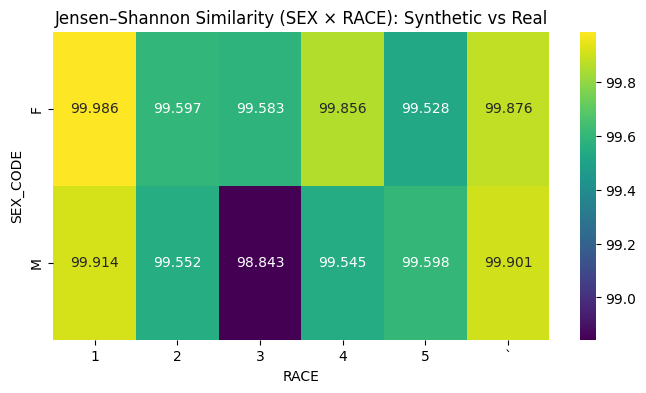

Jensen–Shannon Similarity Matrix (2×5):
RACE            1        2        3        4        5        `
SEX_CODE                                                      
F         99.9859  99.5970  99.5833  99.8560  99.5280  99.8756
M         99.9137  99.5515  98.8431  99.5452  99.5981  99.9013


In [44]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import jensenshannon
import seaborn as sns
import matplotlib.pyplot as plt

# Cross-tabulate race × sex for both real and synthetic data
ct_real = pd.crosstab(df_train['SEX_CODE'], df_train['RACE'], normalize='index')
ct_synth = pd.crosstab(df['SEX_CODE'], df['RACE'], normalize='index')

# ✅ Keep only the first two SEX_CODEs (e.g., 0 and 1)
ct_real = ct_real.iloc[:2, :]
ct_synth = ct_synth.iloc[:2, :]

# Align indices and columns to ensure identical shape
ct_real, ct_synth = ct_real.align(ct_synth, fill_value=0)

# ✅ Initialize result matrix (2×5)
js_matrix = pd.DataFrame(index=ct_real.index, columns=ct_real.columns, dtype=float)

# ✅ Compute cell-level JS similarities
for sex in ct_real.index:
    for race in ct_real.columns:
        # Create 2-point probability vectors (value vs complement)
        p = np.array([ct_real.loc[sex, race], 1 - ct_real.loc[sex, race]])
        q = np.array([ct_synth.loc[sex, race], 1 - ct_synth.loc[sex, race]])
        js_matrix.loc[sex, race] = (1 - jensenshannon(p, q)) * 100

# ✅ Plot 2×5 heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(js_matrix, annot=True, cmap="viridis", fmt=".3f")
plt.title("Jensen–Shannon Similarity (SEX × RACE): Synthetic vs Real")
plt.xlabel("RACE")
plt.ylabel("SEX_CODE")
plt.show()

# ✅ Print 2×5 JS matrix
print("Jensen–Shannon Similarity Matrix (2×5):")
print(js_matrix.round(4))


In [36]:
# list(race_labels.values())
js_matrix.rename(index = {'1':'American', 2:'Asian', 3:'Black', 4:'White', 5:'Other'}, inplace=True)
js_matrix


RACE,1,2,3,4,5,`
SEX_CODE,,,,,,
F,99.985858,99.597008,99.583346,99.856001,99.528042,99.875608
M,99.913731,99.551536,98.843087,99.545189,99.598124,99.901302


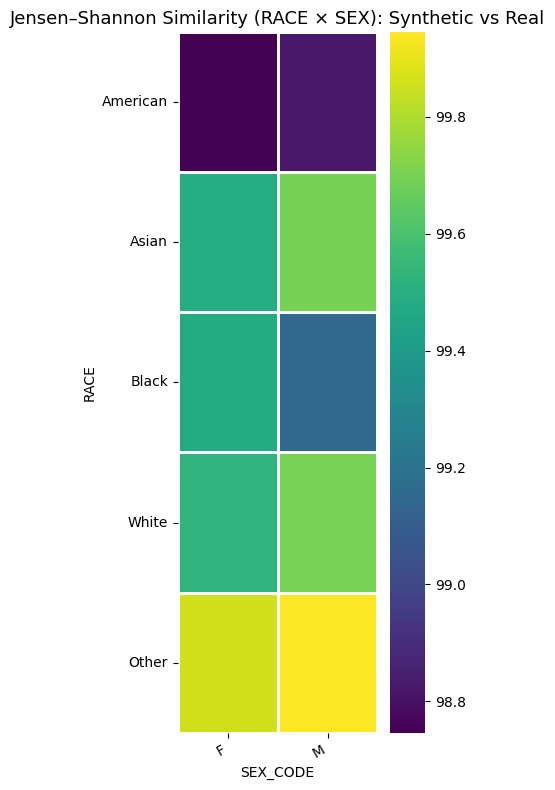

Jensen–Shannon Similarity Matrix (RACE × SEX):
              F      M
RACE                  
American  98.75  98.83
Asian     99.49  99.70
Black     99.48  99.15
White     99.53  99.70
Other     99.86  99.94


In [37]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import jensenshannon
import seaborn as sns
import matplotlib.pyplot as plt

# Cross-tabulate (RACE × SEX_CODE)
ct_real = pd.crosstab(df_train['RACE'], df_train['SEX_CODE'], normalize='index')
ct_synth = pd.crosstab(df['RACE'], df['SEX_CODE'], normalize='index')

# Keep only the first two SEX_CODEs (0 and 1)
ct_real = ct_real.iloc[:, :2]
ct_synth = ct_synth.iloc[:, :2]

# Align indices and columns
ct_real, ct_synth = ct_real.align(ct_synth, fill_value=0)

# Initialize result matrix (5 × 2) and ensure numeric type
js_matrix = pd.DataFrame(index=ct_real.index, columns=ct_real.columns, dtype=float)

# Compute cell-level JS similarities
for race in ct_real.index:
    for sex in ct_real.columns:
        p = np.array([ct_real.loc[race, sex], 1 - ct_real.loc[race, sex]])
        q = np.array([ct_synth.loc[race, sex], 1 - ct_synth.loc[race, sex]])
        js_matrix.loc[race, sex] = float((1 - jensenshannon(p, q)) * 100)  # ensure float

# Optional: remove last race row if needed
js_matrix = js_matrix.iloc[:-1, :]

# Race labels for columns
race_labels = {
    1: "American Indian/Eskimo/Aleut",
    2: "Asian or Pacific Islander",
    3: "Black",
    4: "White",
    5: "Other"
}
js_matrix.columns = [race_labels.get(col, col) for col in js_matrix.columns]  # map columns

js_matrix.rename(columns = race_labels, inplace=True)

js_matrix.rename(index = {'1':'American', '2':'Asian', '3':'Black', '4':'White', '5':'Other'}, inplace=True)


# Convert DataFrame to numeric to ensure heatmap shows annotations
js_matrix = js_matrix.astype(float)

# Plot heatmap with numeric SEX_CODE as rows, race labels as columns
plt.figure(figsize=(4, 8))
sns.heatmap(
    js_matrix,
    annot=False,        # show values
    fmt=".1f",         # format values
    cmap="viridis",
    cbar=True,
    linewidths=0.8,    # separators
    linecolor='white'
)
plt.title("Jensen–Shannon Similarity (RACE × SEX): Synthetic vs Real", fontsize=13)
plt.xlabel("SEX_CODE")
plt.ylabel("RACE")
plt.yticks(rotation=0)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

# Print JS matrix
print("Jensen–Shannon Similarity Matrix (RACE × SEX):")
print(js_matrix.round(2))


In [38]:
js_matrix.iloc[:-1,:]

,F,M
RACE,,
American,98.746593,98.825209
Asian,99.488052,99.695418
Black,99.480194,99.151466
White,99.525100,99.700692


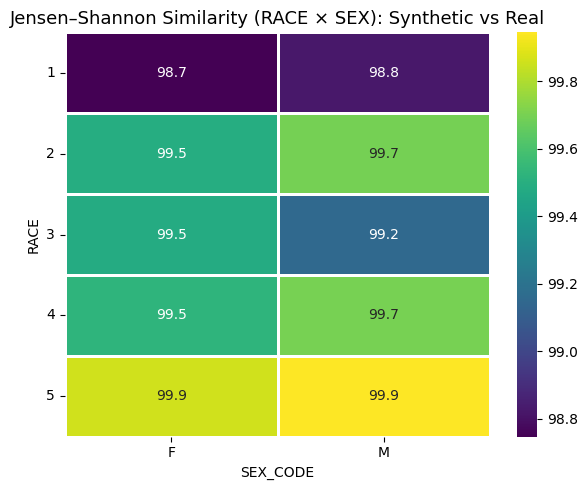

Jensen–Shannon Similarity Matrix (RACE × SEX):
SEX_CODE      F      M
RACE                  
1         98.75  98.83
2         99.49  99.70
3         99.48  99.15
4         99.53  99.70
5         99.86  99.94


In [39]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import jensenshannon
import seaborn as sns
import matplotlib.pyplot as plt

# Cross-tabulate (RACE × SEX_CODE)
ct_real = pd.crosstab(df_train['RACE'], df_train['SEX_CODE'], normalize='index')
ct_synth = pd.crosstab(df['RACE'], df['SEX_CODE'], normalize='index')

# Keep only the first two SEX_CODEs (e.g., 0 and 1)
ct_real = ct_real.iloc[:, :2]
ct_synth = ct_synth.iloc[:, :2]

# Align indices and columns
ct_real, ct_synth = ct_real.align(ct_synth, fill_value=0)

# Initialize result matrix (5×2)
js_matrix = pd.DataFrame(index=ct_real.index, columns=ct_real.columns, dtype=float)

# Compute cell-level JS similarities
for race in ct_real.index:
    for sex in ct_real.columns:
        p = np.array([ct_real.loc[race, sex], 1 - ct_real.loc[race, sex]])
        q = np.array([ct_synth.loc[race, sex], 1 - ct_synth.loc[race, sex]])
        js_matrix.loc[race, sex] = (1 - jensenshannon(p, q)) * 100

# Optionally remove last race row if not needed
js_matrix = js_matrix.iloc[:-1, :]

# Plot heatmap with numeric race codes
plt.figure(figsize=(6, 5))
sns.heatmap(
    js_matrix,
    annot=True,       # Show JS values in cells
    fmt=".1f",
    cmap="viridis",
    cbar=True,
    linewidths=0.8,   # Cell separators
    linecolor='white'
)
plt.title("Jensen–Shannon Similarity (RACE × SEX): Synthetic vs Real", fontsize=13)
plt.xlabel("SEX_CODE")
plt.ylabel("RACE")
plt.yticks(rotation=0)  # Keep numbers horizontal
plt.tight_layout()
plt.show()

# Print JS matrix with numeric race codes
print("Jensen–Shannon Similarity Matrix (RACE × SEX):")
print(js_matrix.round(2))


In [40]:
df['ETHNICITY'] = pd.to_numeric(df['ETHNICITY'], errors='coerce')
df['ETHNICITY'].value_counts()

df_train['ETHNICITY'] = pd.to_numeric(df_train['ETHNICITY'], errors='coerce')
df_train['ETHNICITY'].value_counts()


ETHNICITY
2.0    70393
1.0    29606
Name: count, dtype: int64

In [41]:
ct_real = pd.crosstab(df_train['ETHNICITY'], df_train['RACE'], normalize='index')
ct_synth = pd.crosstab(df['ETHNICITY'], df['RACE'], normalize='index')
ct_real.iloc[:,:]

RACE,1,2,3,4,5
ETHNICITY,,,,,
1.0,0.003074,0.002331,0.005776,0.710025,0.278795
2.0,0.001875,0.031125,0.221897,0.685722,0.059381


In [107]:
df['PAT_AGE'] = pd.to_numeric(df['PAT_AGE'], errors='coerce')
df['PAT_AGE'].value_counts()
df_train['PAT_AGE'] = pd.to_numeric(df_train['PAT_AGE'], errors='coerce')
df_train['PAT_AGE'].value_counts()

df['APR_MDC'] = pd.to_numeric(df['APR_MDC'], errors='coerce')
df['APR_MDC'].value_counts()
df_train['APR_MDC'] = pd.to_numeric(df_train['APR_MDC'], errors='coerce')
df_train['APR_MDC'].value_counts()



APR_MDC
4     13857
1     12386
5     11361
14     9510
18     9252
6      8126
8      6453
11     3915
19     3414
10     3292
7      3090
9      2579
16     1914
21     1581
20     1226
3      1198
25      947
17      889
13      801
23      756
15      695
24      681
12      631
2       628
22      538
0       280
Name: count, dtype: int64

In [108]:
js_matrix

RACE,American_,Asian or Pacific Islander,Black,White,Other
ETHNICITY,,,,,
Hispanic,99.927410,99.951143,99.596891,99.731862,99.653805
NOn-Hispanic,99.984395,99.962849,99.957536,99.868099,99.698684


In [109]:
# pd.DataFrame(icd_map([1,2,4]), columns=['num','idc_10'])
ll = list(df["APR_MDC"].value_counts().index)
APR_MDC_MAP = icd_map(ll)
names = [item[1] for item in APR_MDC_MAP]
names

['Circulatory System',
 'Infectious & Parasitic Diseases',
 'Respiratory System',
 'Digestive System',
 'Nervous System',
 'Pregnancy, Childbirth & Puerperium',
 'Musculoskeletal System & Connective Tissue',
 'Kidney & Urinary Tract',
 'Hepatobiliary System & Pancreas',
 'Endocrine, Nutritional & Metabolic',
 'Skin, Subcutaneous Tissue & Breast',
 'Mental Diseases & Disorders',
 'Blood & Blood Forming Organs, Immunological',
 'Injuries, Poisonings, Toxic Effects',
 'Alcohol/Drug Use & Mental Disorders',
 'Ear, Nose, Mouth, Throat',
 'Human Immunodeficiency Virus Infections',
 'Myeloproliferative Diseases & Neoplasms',
 'Other Factors Influencing Health Status',
 'Female Reproductive System',
 'Multiple Significant Trauma',
 'Male Reproductive System',
 'Eye',
 'Newborn & Other Neonates',
 'Burns',
 'Unknown/Other']

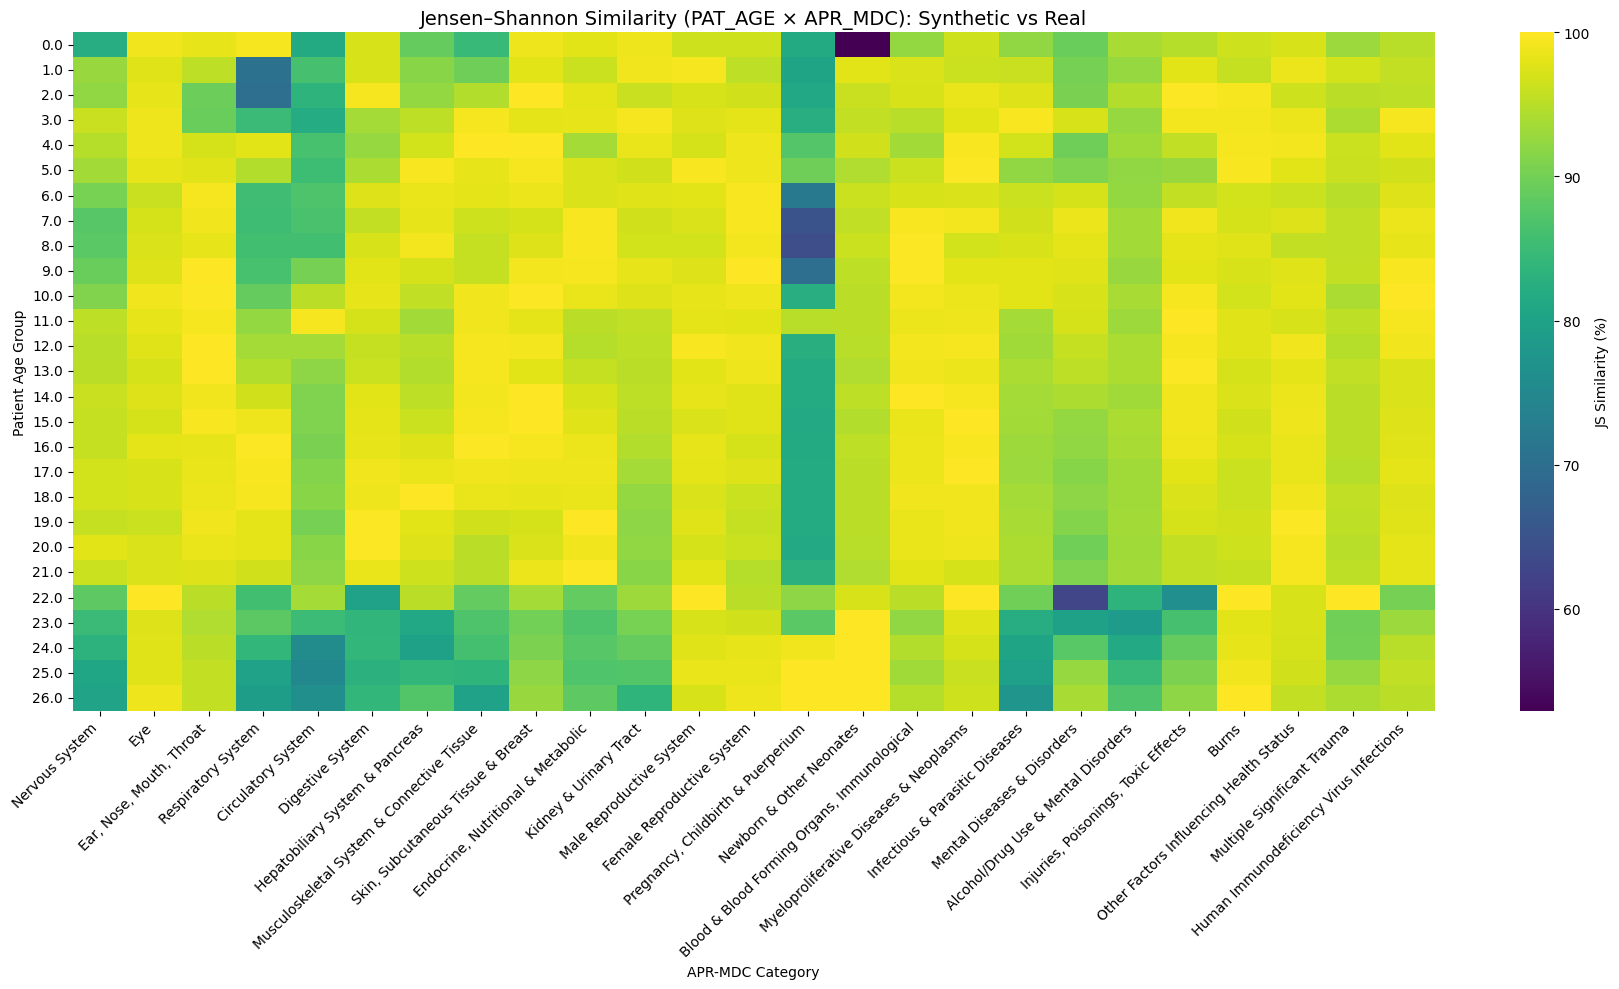

✅  Similarity Matrix (PAT_AGE × APR_MDC):
APR_MDC  Nervous System     Eye  Ear, Nose, Mouth, Throat  Respiratory System  \
PAT_AGE                                                                         
0.0               82.26   98.90                     98.19               99.38   
1.0               92.74   97.75                     95.28               70.62   
2.0               92.22   98.33                     89.47               69.71   
3.0               96.02   98.76                     89.31               84.76   
4.0               94.71   98.77                     96.94               97.93   
5.0               93.53   98.29                     97.64               94.50   
6.0               90.28   96.06                     99.35               85.60   
7.0               87.63   97.02                     99.01               85.35   
8.0               87.90   97.38                     98.27               85.81   
9.0               89.26   97.47                     99.92          

In [111]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import jensenshannon
import seaborn as sns
import matplotlib.pyplot as plt

# ---- Cross-tabulate PAT_AGE × APR_MDC ----
ct_real = pd.crosstab(df_train['PAT_AGE'], df_train['APR_MDC'], normalize='index')
ct_synth = pd.crosstab(df['PAT_AGE'], df['APR_MDC'], normalize='index')

# Align both tables
ct_real, ct_synth = ct_real.align(ct_synth, fill_value=0)

# Initialize Jensen–Shannon result matrix
js_matrix = pd.DataFrame(index=ct_real.index, columns=ct_real.columns, dtype=float)

# ---- Compute JS Similarities ----
for age in ct_real.index:
    for mdc in ct_real.columns:
        p = np.array([ct_real.loc[age, mdc], 1 - ct_real.loc[age, mdc]])
        q = np.array([ct_synth.loc[age, mdc], 1 - ct_synth.loc[age, mdc]])
        js_matrix.loc[age, mdc] = (1 - jensenshannon(p, q)) * 100

# ---- APR-MDC Mapping ----
APR_MDC_MAP = {
    1: "Nervous System",
    2: "Eye",
    3: "Ear, Nose, Mouth, Throat",
    4: "Respiratory System",
    5: "Circulatory System",
    6: "Digestive System",
    7: "Hepatobiliary System & Pancreas",
    8: "Musculoskeletal System & Connective Tissue",
    9: "Skin, Subcutaneous Tissue & Breast",
    10: "Endocrine, Nutritional & Metabolic",
    11: "Kidney & Urinary Tract",
    12: "Male Reproductive System",
    13: "Female Reproductive System",
    14: "Pregnancy, Childbirth & Puerperium",
    15: "Newborn & Other Neonates",
    16: "Blood & Blood Forming Organs, Immunological",
    17: "Myeloproliferative Diseases & Neoplasms",
    18: "Infectious & Parasitic Diseases",
    19: "Mental Diseases & Disorders",
    20: "Alcohol/Drug Use & Mental Disorders",
    21: "Injuries, Poisonings, Toxic Effects",
    22: "Burns",
    23: "Other Factors Influencing Health Status",
    24: "Multiple Significant Trauma",
    25: "Human Immunodeficiency Virus Infections"
}

# ---- Remove 0 column if exists ----
if 0 in js_matrix.columns:
    js_matrix = js_matrix.drop(columns=0)

# Ensure integer column type before renaming
js_matrix.columns = js_matrix.columns.astype(int)

# Rename columns to descriptive APR-MDC labels
js_matrix.rename(columns=APR_MDC_MAP, inplace=True)

# ---- Plot Heatmap ----
plt.figure(figsize=(18, 10))
sns.heatmap(js_matrix, annot=False, fmt=".2f", cmap="viridis", cbar_kws={'label': 'JS Similarity (%)'})
plt.title("Jensen–Shannon Similarity (PAT_AGE × APR_MDC): Synthetic vs Real", fontsize=14)
plt.xlabel("APR-MDC Category")
plt.ylabel("Patient Age Group")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ---- Print Result ----
print("✅  Similarity Matrix (PAT_AGE × APR_MDC):")
print(js_matrix.round(2))


       S     E  day  interventions       I      R
0  98969  1031    0         100000     NaN    NaN
1  97959  1643    1         100000   398.0    NaN
2  97003  1760    2         100000  1222.0   15.0
3  96076  1735    3         100000  2091.0   98.0
4  95104  1781    4         100000  2794.0  321.0


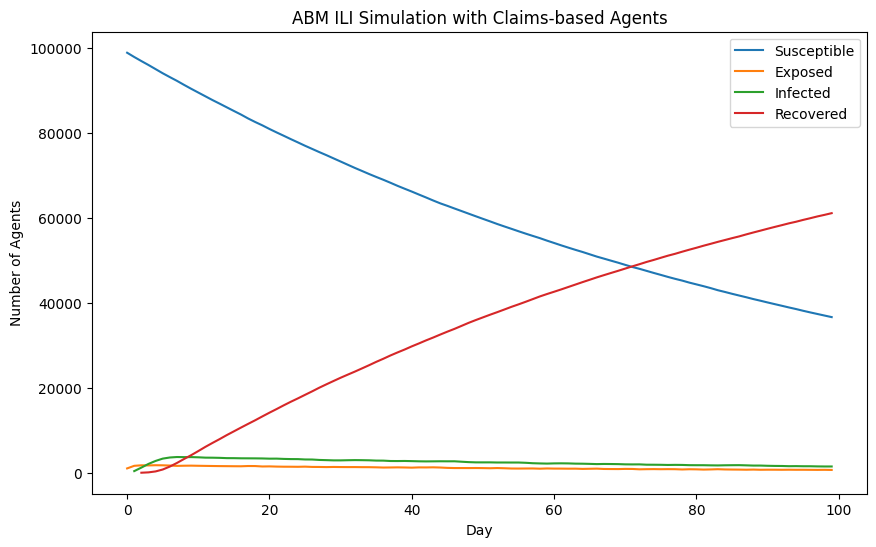

In [1]:
# ===========================================
# ABM Simulation for ILI using Claims Data
# ===========================================

import numpy as np
import pandas as pd
import random

# --------------------------
# 1. Load claims data
# --------------------------
# You can replace this with your real or synthetic claims CSV
# Expected columns: 
# ['agent_id', 'age', 'comorbidity_score', 'region', 'baseline_outpatient_prob',
#  'baseline_er_prob', 'baseline_inpatient_prob', 'historical_claims_count']

# For demonstration, we will generate synthetic claims-like data
num_agents = 100000  # number of agents

np.random.seed(42)  # reproducibility

agents_df = pd.DataFrame({
    'agent_id': np.arange(num_agents),
    'age': np.random.randint(0, 90, num_agents),
    'comorbidity_score': np.random.poisson(1.5, num_agents),
    'region': np.random.choice(['North', 'South', 'East', 'West'], num_agents),
    'baseline_outpatient_prob': np.random.uniform(0.1, 0.5, num_agents),
    'baseline_er_prob': np.random.uniform(0.05, 0.2, num_agents),
    'baseline_inpatient_prob': np.random.uniform(0.01, 0.1, num_agents),
    'historical_claims_count': np.random.poisson(2, num_agents)
})

# --------------------------
# 2. Initialize ABM agent states
# --------------------------
# S: susceptible, E: exposed, I: infected, R: recovered
agents_df['state'] = 'S'
agents_df['days_in_state'] = 0  # counter for progression
agents_df['intervention'] = False  # whether agent receives policy intervention

# --------------------------
# 3. Disease parameters
# --------------------------
# These probabilities can be derived from historical claims
incubation_period_mean = 2   # days from E -> I
infectious_period_mean = 5   # days from I -> R

# Severity probabilities conditional on infection
# These can be derived from claim type frequencies
def get_severity_probs(agent):
    """Return outpatient, ER, inpatient probabilities for infected agent"""
    return (
        agent['baseline_outpatient_prob'],
        agent['baseline_er_prob'],
        agent['baseline_inpatient_prob']
    )

# --------------------------
# 4. Policy functions
# --------------------------

def early_outpatient_policy(agent):
    """
    Example: Early warning policy increases outpatient care probability
    """
    agent['baseline_outpatient_prob'] = min(agent['baseline_outpatient_prob'] + 0.2, 0.9)
    agent['intervention'] = True
    return agent

def high_risk_intervention(agent):
    """
    Target high-risk agents (elderly or comorbidity) for interventions
    """
    if agent['age'] > 65 or agent['comorbidity_score'] >= 3:
        agent['baseline_outpatient_prob'] = min(agent['baseline_outpatient_prob'] + 0.3, 0.95)
        agent['baseline_inpatient_prob'] = max(agent['baseline_inpatient_prob'] - 0.1, 0.01)
        agent['intervention'] = True
    return agent

# --------------------------
# 5. Simulation function
# --------------------------
def simulate_ABM(agents, days=30, apply_policy=False):
    """
    Run ABM simulation for specified number of days.
    apply_policy: if True, apply early warning / high-risk policies
    """
    daily_stats = []

    for day in range(days):
        # Apply policies if flagged
        if apply_policy:
            agents = agents.apply(early_outpatient_policy, axis=1)
            agents = agents.apply(high_risk_intervention, axis=1)

        # Iterate over agents
        for idx, agent in agents.iterrows():
            # Susceptible -> Exposed (infection)
            if agent['state'] == 'S':
                # Simple random infection risk
                infection_prob = 0.01  # can be tuned based on real claims-derived ILI rate
                if random.random() < infection_prob:
                    agents.at[idx, 'state'] = 'E'
                    agents.at[idx, 'days_in_state'] = 0

            # Exposed -> Infected
            elif agent['state'] == 'E':
                agents.at[idx, 'days_in_state'] += 1
                if agents.at[idx, 'days_in_state'] >= np.random.poisson(incubation_period_mean):
                    agents.at[idx, 'state'] = 'I'
                    agents.at[idx, 'days_in_state'] = 0

            # Infected -> Recovered
            elif agent['state'] == 'I':
                agents.at[idx, 'days_in_state'] += 1

                # Determine severity type for claims generation
                outpatient_p, er_p, inpatient_p = get_severity_probs(agent)
                severity_roll = random.random()
                if severity_roll < outpatient_p:
                    severity = 'outpatient'
                elif severity_roll < outpatient_p + er_p:
                    severity = 'ER'
                else:
                    severity = 'inpatient'

                # Generate synthetic claim
                agents.at[idx, 'last_claim'] = severity

                if agents.at[idx, 'days_in_state'] >= np.random.poisson(infectious_period_mean):
                    agents.at[idx, 'state'] = 'R'
                    agents.at[idx, 'days_in_state'] = 0

        # Collect daily stats
        daily_summary = agents['state'].value_counts().to_dict()
        daily_summary['day'] = day
        daily_summary['interventions'] = agents['intervention'].sum()
        daily_stats.append(daily_summary)

    return pd.DataFrame(daily_stats), agents

# --------------------------
# 6. Run simulation
# --------------------------
daily_stats, final_agents = simulate_ABM(agents_df, days=100, apply_policy=True)

# --------------------------
# 7. Inspect results
# --------------------------
print(daily_stats.head())

# Example visualization (requires matplotlib)
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(daily_stats['day'], daily_stats.get('S', [0]*30), label='Susceptible')
plt.plot(daily_stats['day'], daily_stats.get('E', [0]*30), label='Exposed')
plt.plot(daily_stats['day'], daily_stats.get('I', [0]*30), label='Infected')
plt.plot(daily_stats['day'], daily_stats.get('R', [0]*30), label='Recovered')
plt.xlabel('Day')
plt.ylabel('Number of Agents')
plt.title('ABM ILI Simulation with Claims-based Agents')
plt.legend()
plt.show()
